# <center>Group-LASSO-problem 作业</center>

<center>李锦韬 2201213292</center>

本文档为 Group-LASSO-problem 作业的实验报告，用于进一步拓展说明README中的内容。

## 问题描述

考虑以下问题：

$$
\min _{x \in \mathbb{R}^{n \times l}} \frac{1}{2}\|A x-b\|_F^2+\mu\|x\|_{1,2}
$$

其中 $A \in \mathbb{R}^{m \times n}$, $b \in \mathbb{R}^{m \times l}$, $\mu>0$ 并且

$$
\|x\|_{1,2}=\sum_{i=1}^n\|x_{(i, 1: l)}\|_2
$$

其中 $x_{(i, 1: l)}$ 是矩阵 $x$ 的第 $i$ 行。

## 评价指标
本项目将使用以下指标来评价各个算法的性能：

- 算法得到的最终目标函数值 和 最优解对应的目标函数 之间的绝对值差 `Obj_ABS_Error`
- 算法得到的最终解 和 最优解 之间的 归一化 Frobenius 范数差 `x_u_Error`
- （对于非 mosek 和 gurobi 等自行编写的算法）对比其和此两者成熟求解器所得解之间的归一化 Frobenius 范数差 `x_CVXmosek_Error` 和 `x_CVXgurobi_Error`
- 算法求解的运行时间 `Time(s)`
- 算法求解的迭代次数 `Iter`
- 算法得到的最终解的稀疏度 `Sparsity`

下面具体地介绍各个指标的计算方法：

`Obj_ABS_Error` 的计算方法如下：
$$
Error_{f} = |f_{x} - f_{u}|
$$

其中 $f_{x}$ 为算法得到的最终目标函数值，$f_{u}$ 为最优解 $u$ 对应的目标函数值。

`x_u_Error` 的计算方法如下：
$$
Error(x, u) = \frac{\|x - u\|_F}{1 + \|u\|_F}
$$

其中 $x$ 为算法得到的最终解，$u$ 为最优解。

`x_CVXmosek_Error` 和 `x_CVXgurobi_Error` 的计算方法如下：
$$
Error(x, x_{cvx}) = \frac{\|x - x_{cvx}\|_F}{1 + \|x_{cvx}\|_F}
$$

其中 $x$ 为算法得到的最终解，$x_{cvx}$ 为使用 cvxpy + mosek 或 cvxpy + gurobi 求解得到的最优解。

`Sparsity` 的计算方法如下：

$$
Sparsity = \frac{\|x\|_0}{n \times l}
$$

其中 $x$ 为算法得到的最终解，$\|x\|_0$ 表示 $x$ 中非零元素的个数，在本项目中认为绝对值小于 $10^{-5}$ 的元素为零。


## CVX 求解

使用 CVX 软件包可以直接求解上述问题，无需变换问题形式。直接将 `X` 设为变量，并根据问题描述写出目标函数即可。

需要注意的是：本项目使用 CVX 的 python 版本，即 CVXPY，版本信息在README文件中。CVX 记录的迭代信息是通过 `verbose=True` 来实现的，由于其无法直接被读取和存储，本项目使用重定向 `stdout` 输出到文件的技巧记录迭代信息，之后采用正则表达式匹配的方式提取迭代信息。

代码的最后一步中的求解器可以分别选择 mosek 和 gurobi。
例如下面的形式：

In [ ]:
import numpy as np
import cvxpy as cp
def gl_cvx_mosek(x0: np.ndarray, A: np.ndarray, b: np.ndarray, mu: float, opts={}):
    X = cp.Variable(shape=(A.shape[1], b.shape[1]))
    X.value = x0
    objective = cp.Minimize(0.5 * cp.square(cp.norm(A @ X - b, 'fro')) + mu * cp.sum(cp.norm(X, 2, 1)))
    problem = cp.Problem(objective)
    problem.solve(solver=cp.MOSEK, verbose=True)

运行本项目编写的测试脚本，最终结果和迭代曲线如下所示。

可以注意到：

- CVX 可以自行转换相应的目标函数和约束条件，使其符合 mosek 和 gurobi 的要求；
- mosek 和 gurobi 的求解效率相差不大，但是 mosek 求解速度更快，单位迭代步所需时间也更少。
- mosek 和 gurobi 两者最终得到的解差别不大，从数值上几乎相同。
- gurobi 第一次迭代的目标函数值为负数值，可能是由于求解器初始求解时的特殊策略所致。




Solver        Objective    Obj_ABS_Error    x_u_Error    Time(s)    Iter    Sparsity
----------  -----------  ---------------  -----------  ---------  ------  ----------
cvx_mosek      0.652291      1.36211e-05  3.9124e-05    0.449454      13    0.102539
cvx_gurobi     0.652291      1.33551e-05  3.75525e-05   0.858079      12    0.102539


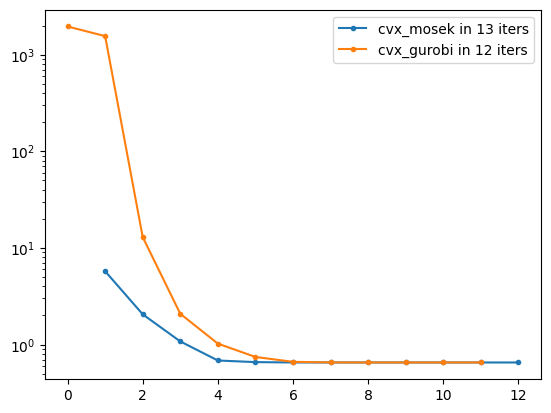

<Figure size 640x480 with 0 Axes>

In [1]:
%matplotlib inline
%run Test_group_lasso.py -S gl_cvx_mosek gl_cvx_gurobi -P -L ERROR

## Mosek 和 gurobi 求解

Mosek 和 gurobi 同样拥有对应的 python 软件包，可以直接调用。但是由于其要求问题形式必须为标准形式，因此需要对原问题进行变换。

### Mosek

对于 Mosek，需要进行变量替换，将难以处理的范数放入约束锥中，原问题转换为如下形式：

$$
\begin{align}
    & \underset{t, z}{\min} & & \frac{1}{2} t + \mu \sum_{i=1}^{n} z_i \\
    & \text{s.t.} & & Ax - b = y \\
    & & & \begin{bmatrix}
        1 + t \\
        2 \times \text{vec}(y) \\
        1 - t
    \end{bmatrix} \in \mathcal{Q}_c \\
    & & & \begin{bmatrix}
        z_i \\
        (x_{i,:})^T
    \end{bmatrix} \in \mathcal{Q}_c, \quad \forall i = 1, \ldots, n
\end{align}
$$


其中 $\mathcal{Q}_c$ 表示二次锥，$\text{vec}(y)$ 表示矩阵 y$ 的向量化，即将矩阵按列展开成一个向量。

### gurobi

对于 gurobi，只需要处理后半部分的组范数即可，不需要二次锥，原问题转换为如下形式：

$$

\begin{align}
    & \underset{y, z}{\min} & & \frac{1}{2} \|y\|_F^2 + \mu \sum_{i=1}^{n} z_i \\
    & \text{s.t.} & & Ax - b = y \\
    & & & \|x_{(i, : )}\|_2 \leq z_i, \quad \forall i = 1, \ldots, n
\end{align}

$$


## SGD

次梯度算法



Solver        Objective    Obj_ABS_Error    x_u_Error    Time(s)    Iter    Sparsity
----------  -----------  ---------------  -----------  ---------  ------  ----------
SGD_primal     0.652294      1.02855e-05  5.52482e-05   0.687138    1473    0.121094


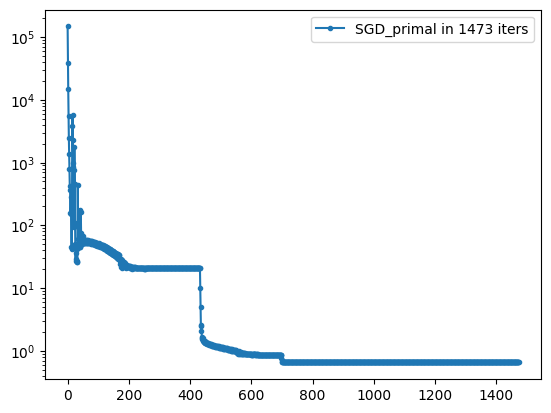

<Figure size 640x480 with 0 Axes>

In [2]:
%matplotlib inline
%run Test_group_lasso.py -S gl_SGD_primal -P -L ERROR

## ProxGD & FProxGD



Solver            Objective    Obj_ABS_Error    x_u_Error    Time(s)    Iter    Sparsity
--------------  -----------  ---------------  -----------  ---------  ------  ----------
ProxGD_primal      0.652291      1.36421e-05  3.89562e-05   0.188491     190    0.102539
FProxGD_primal     0.652291      1.36421e-05  3.8964e-05    0.249137     486    0.102539


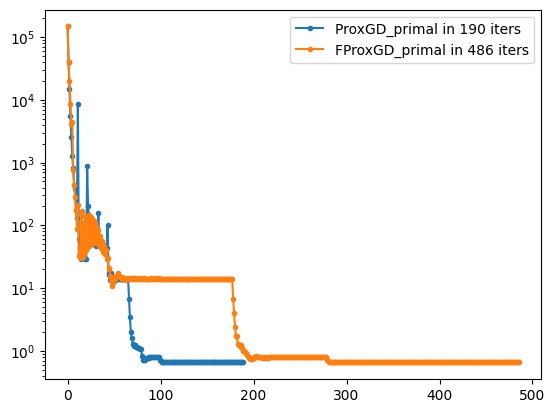

<Figure size 640x480 with 0 Axes>

In [3]:
%matplotlib inline
%run Test_group_lasso.py -S gl_ProxGD_primal gl_FProxGD_primal -P -L ERROR

## ALM



Solver      Objective    Obj_ABS_Error    x_u_Error    Time(s)    Iter    Sparsity
--------  -----------  ---------------  -----------  ---------  ------  ----------
ALM_dual     0.652308      3.97276e-06  6.83455e-05   0.238295      70   0.0996094


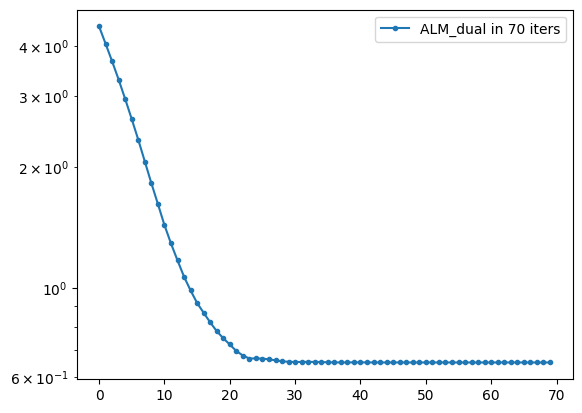

<Figure size 640x480 with 0 Axes>

In [4]:
%matplotlib inline
%run Test_group_lasso.py -S gl_ALM_dual -P -L ERROR

## ADMN



Solver         Objective    Obj_ABS_Error    x_u_Error    Time(s)    Iter    Sparsity
-----------  -----------  ---------------  -----------  ---------  ------  ----------
ADMM_dual       0.652309      4.80892e-06  6.84793e-05  0.0688348      86   0.0996094
ADMM_primal     0.652291      1.34764e-05  3.8987e-05   0.625333     2694   0.102539


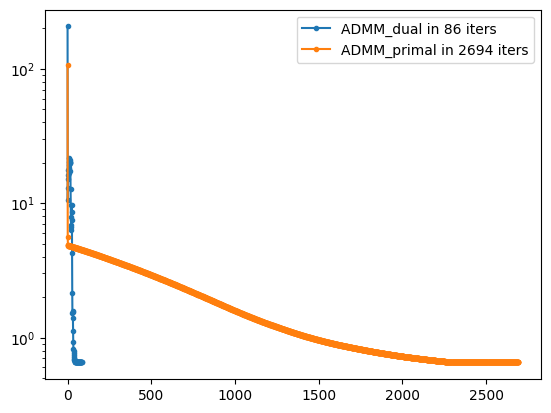

<Figure size 640x480 with 0 Axes>

In [6]:
%matplotlib inline
%run Test_group_lasso.py -S gl_ADMM_dual gl_ADMM_primal -P -L ERROR

## 结果对比



Solver            Objective    Obj_ABS_Error    x_u_Error    Time(s)    Iter    Sparsity
--------------  -----------  ---------------  -----------  ---------  ------  ----------
cvx_mosek          0.652291      1.36211e-05  3.9124e-05    0.457622      13   0.102539
cvx_gurobi         0.652291      1.33551e-05  3.75525e-05   0.854337      12   0.102539
mosek              0.652301      3.33869e-06  9.84223e-06   0.389467      11   0.0996094
gurobi             0.652291      1.33727e-05  3.97062e-05   0.615674      13   0.103516
SGD_primal         0.652294      1.02855e-05  5.52482e-05   0.78305     1473   0.121094
ProxGD_primal      0.652291      1.36421e-05  3.89562e-05   0.18628      190   0.102539
FProxGD_primal     0.652291      1.36421e-05  3.8964e-05    0.278375     486   0.102539
ALM_dual           0.652308      3.97276e-06  6.83455e-05   0.246139      70   0.0996094
ADMM_dual          0.652309      4.80892e-06  6.84793e-05   0.073714      86   0.0996094
ADMM_primal        0.6522

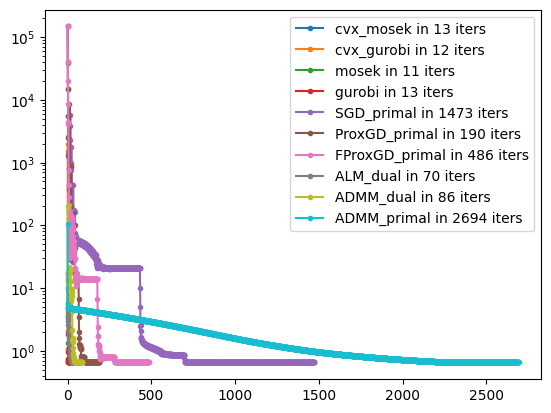

<Figure size 640x480 with 0 Axes>

In [1]:
%matplotlib inline
%run Test_group_lasso.py -S all -P -L ERROR

In [1]:
%run Test_group_lasso.py -S all -L ERROR -C



Solver            Objective    Obj_ABS_Error    x_u_Error    x_CVXmosek_Error    x_CVXgurobi_Error    Time(s)    Iter    Sparsity
--------------  -----------  ---------------  -----------  ------------------  -------------------  ---------  ------  ----------
cvx_mosek          0.652291      1.36211e-05  3.9124e-05          0                    2.06309e-06  0.468511       13   0.102539
cvx_gurobi         0.652291      1.33551e-05  3.75525e-05         2.0631e-06           0            0.828498       12   0.102539
mosek              0.652301      3.33869e-06  9.84223e-06         2.92829e-05          2.77187e-05  0.362566       11   0.0996094
gurobi             0.652291      1.33727e-05  3.97062e-05         8.27779e-07          2.54051e-06  0.591821       13   0.103516
SGD_primal         0.652294      1.02855e-05  5.52482e-05         1.89914e-05          2.03863e-05  0.724858     1473   0.121094
ProxGD_primal      0.652291      1.36421e-05  3.89562e-05         3.16137e-07          1.995